In [5]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne_icalabel import label_components
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [6]:
def Extractive(file):
    original_data = scio.loadmat(file)
    samples = original_data['samples'].transpose()
    ch_names = ['FZ', 'CZ', 'P3', 'PZ', 'P4', 'PO7', 'PO8', 'OZ']
    sfreq = 250
    info = mne.create_info(ch_names, sfreq)
    raw = mne.io.RawArray(samples, info)

    # raw.plot()
    # plt.pause(0)
    inside_data = original_data['data']
    # print(inside_data.dtype)
    # np.set_printoptions(threshold=np.inf)
    # print(inside_data['flash'][0][0])
    flash = inside_data['flash'][0][0]

    # 创建注释
    onset = flash[:, 0]/250
    description = flash[:, 3]
    annot = mne.Annotations(onset=onset, duration=0.125, description=description)
    # print(annot)
    raw.set_annotations(annot)
    # print(samples.shape)
    raw_train = raw.copy()
    raw_test = raw.copy()
    raw_train.crop(tmin=200, tmax=500)
    raw_test.crop(tmin=500, tmax=800)
    '''
    raw_train.plot()
    raw_test.plot()
    plt.pause(0)
    '''
    return raw_train, raw_test

In [7]:
def transform(raw):
    event_id = {'1': 1, '2': 2, '1/2': 2}
    # 重设通道名称
    channel_types = {'FZ': 'eeg', 'CZ': 'eeg', 'P3': 'eeg', 'PZ': 'eeg',
                     'P4': 'eeg', 'PO7': 'eeg', 'PO8': 'eeg', 'OZ': 'eeg'}
    raw.set_channel_types(channel_types)
    events, _ = mne.events_from_annotations(raw, event_id=event_id)   # 将注释转化为events
    # mne.viz.plot_events(events_train, event_id=event_id)                    # 绘制事件发生时间分布图
    # plot一下估计每一个事件持续的长度
    # raw.plot()
    # plt.pause(0)
    epochs = mne.Epochs(raw=raw, events=events, tmin=-0.125, tmax=0.875, event_id=event_id,
                        preload=True, event_repeated='drop')
    return epochs, events

In [8]:
def eeg_power_band(epochs):
    """
    该函数根据epochs的特定频段中的相对功率来创建eeg特征
    使用welch方法可得到83%左右正确率，使用multi方法只得到70%左右，效果不是很好
    """
    # 特定频带
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  # "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}
    spectrum = epochs.compute_psd(method='welch', picks='eeg', fmin=0.5, fmax=30., n_fft=64, n_overlap=10)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # 归一化 PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)
    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))
    # print(X)
    return np.concatenate(X, axis=1)

In [9]:
def classification(epochs_train, epochs_test, event_id, k):
    if k == 0:
        pipe = pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                                    SVC(C=1.2, kernel='linear', random_state=42))
    elif k == 1:
        pipe = pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                                    RandomForestClassifier(n_estimators=100, random_state=42))
    elif k == 2:
        pipe = pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                                    DecisionTreeClassifier(random_state=42))
    # 训练
    y_train = epochs_train.events[:, 2]
    pipe.fit(epochs_train, y_train)

    # 预测
    y_pred = pipe.predict(epochs_test)

    # 评估准确率
    y_test = epochs_test.events[:, 2]
    acc = accuracy_score(y_test, y_pred)

    print("Accuracy score: {}".format(acc))

Creating RawArray with float64 data, n_channels=8, n_times=358372
    Range : 0 ... 358371 =      0.000 ...  1433.484 secs
Ready.
Used Annotations descriptions: ['1', '2']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
862 matching events found
Setting baseline interval to [-0.124, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 251 original time points ...


C:\Users\mimovr\AppData\Local\Temp\ipykernel_6400\3387266202.py:6: RuntimeWarning: The unit for channel(s) CZ, FZ, OZ, P3, P4, PO7, PO8, PZ has changed from NA to V.
  raw.set_channel_types(channel_types)


6 bad epochs dropped
Used Annotations descriptions: ['1', '2']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
833 matching events found
Setting baseline interval to [-0.124, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 833 events and 251 original time points ...
5 bad epochs dropped


C:\Users\mimovr\AppData\Local\Temp\ipykernel_6400\3387266202.py:6: RuntimeWarning: The unit for channel(s) CZ, FZ, OZ, P3, P4, PO7, PO8, PZ has changed from NA to V.
  raw.set_channel_types(channel_types)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\mimovr\AppData\Local\Temp\ipykernel_6400\2637873209.py:17: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
C:\Users\mimovr\AppData\Local\Temp\ipykernel_6400\2637873209.py:17: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\mimovr\AppData\Local\Temp\ipykernel_6400\2637873209.py:17: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
C:\Users\mimovr\AppData\Local\Temp\ipykernel_6400\2637873209.py:17: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,


Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
Accuracy score: 0.8309178743961353
Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
Accuracy score: 0.8309178743961353
Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
Accuracy score: 0.7246376811594203


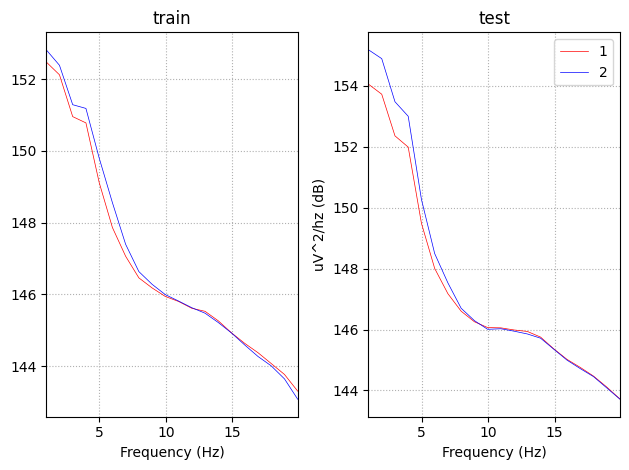

In [10]:
file = 'data/P300S01.mat'
# 从数据集中提取数据
raw_train, raw_test = Extractive(file)
# 生成epochs和events对象
epochs_train, events_train = transform(raw_train)
epochs_test, events_test = transform(raw_test)

'''
特征工程：
将两个事件的epoch综合展示
'''
event_id = {'1': 1, '2': 2}
fig, (ax1, ax2) = plt.subplots(ncols=2)
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2], ['train', 'test'], [epochs_train, epochs_test]):
    for stage, color in zip(stages, ['red', 'blue']):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
        ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='uV^2/hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.tight_layout()
# plt.show()

'''
分类预测
'''
for k in range(3):
    classification(epochs_train, epochs_test, event_id, k)